Détection d’Occupation d’une Salle par Meta-Learning

1. Introduction du Notebook

Dans ce notebook, nous présentons l’ensemble du travail réalisé pour construire un système de détection d’occupation d’une salle à partir de capteurs environnementaux. L’objectif n’était pas seulement d’entraîner un modèle, mais d’aller un peu plus loin avec une approche de meta-learning, où plusieurs classifieurs coopèrent et un meta-modèle décide lequel utiliser.

Notre notebook suit un fil logique : exploration des données → entraînement des modèles → génération des méta-features → meta-modèle → pipeline complet.

2. Importation des Librairies

Ici nous rassemblons les librairies nécessaires pour tout le projet : gestion de données (pandas, numpy), visualisation, modèles scikit-learn, sauvegarde, etc.
Cette cellule sert surtout à centraliser les dépendances.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

# Modèles
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier

# Configuration
%matplotlib inline
sns.set(style="whitegrid")

3. Chargement du Dataset

Dans cette partie, on charge le dataset principal (celui contenant température, humidité, lumière, CO₂, humidity ratio, et étiquette d’occupation).
on vérifie aussi si les colonnes sont cohérentes, et afficher quelques premières lignes pour prendre la température du fichier.

In [2]:
# Chargement des données
df = pd.read_csv('../donnees/datatraining.txt')

# Conversion de la date
df['date'] = pd.to_datetime(df['date'])
df = df.set_index('date')

# Aperçu
print(f"Dimensions du dataset : {df.shape}")
df.head()

Dimensions du dataset : (8143, 6)


,Temperature,Humidity,Light,CO2,HumidityRatio,Occupancy
date,,,,,,
2015-02-04 17:51:00,23.18,27.2720,426.0,721.25,0.004793,1
2015-02-04 17:51:59,23.15,27.2675,429.5,714.00,0.004783,1
2015-02-04 17:53:00,23.15,27.2450,426.0,713.50,0.004779,1
2015-02-04 17:54:00,23.15,27.2000,426.0,708.25,0.004772,1
2015-02-04 17:55:00,23.10,27.2000,426.0,704.50,0.004757,1


4. Analyse Exploratoire Rapide (EDA)

on regarde ici :

les statistiques générales

la distribution de la variable Occupancy

les valeurs extrêmes possibles

la corrélation entre les variables

Quelques graphiques sont produits pour se faire une idée : histogrammes, heatmap, etc.
Cette partie permet de comprendre si certains capteurs influencent plus que d'autres la présence d’occupants.

/tmp/ipykernel_14854/216309382.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(x='Occupancy', data=df, palette='viridis')


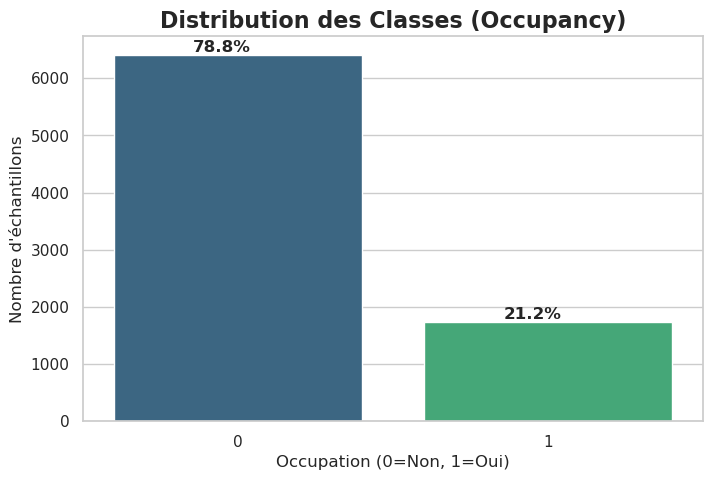

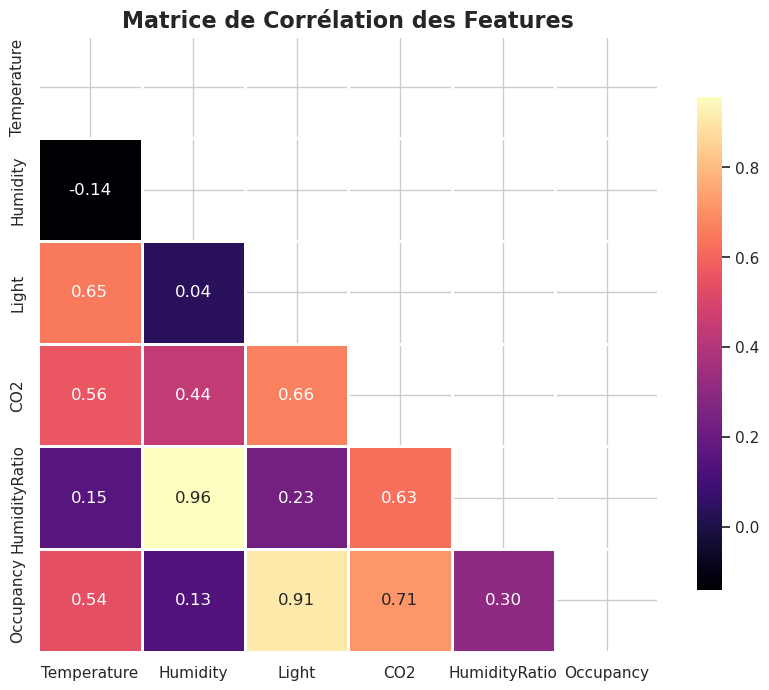

Génération du pairplot...


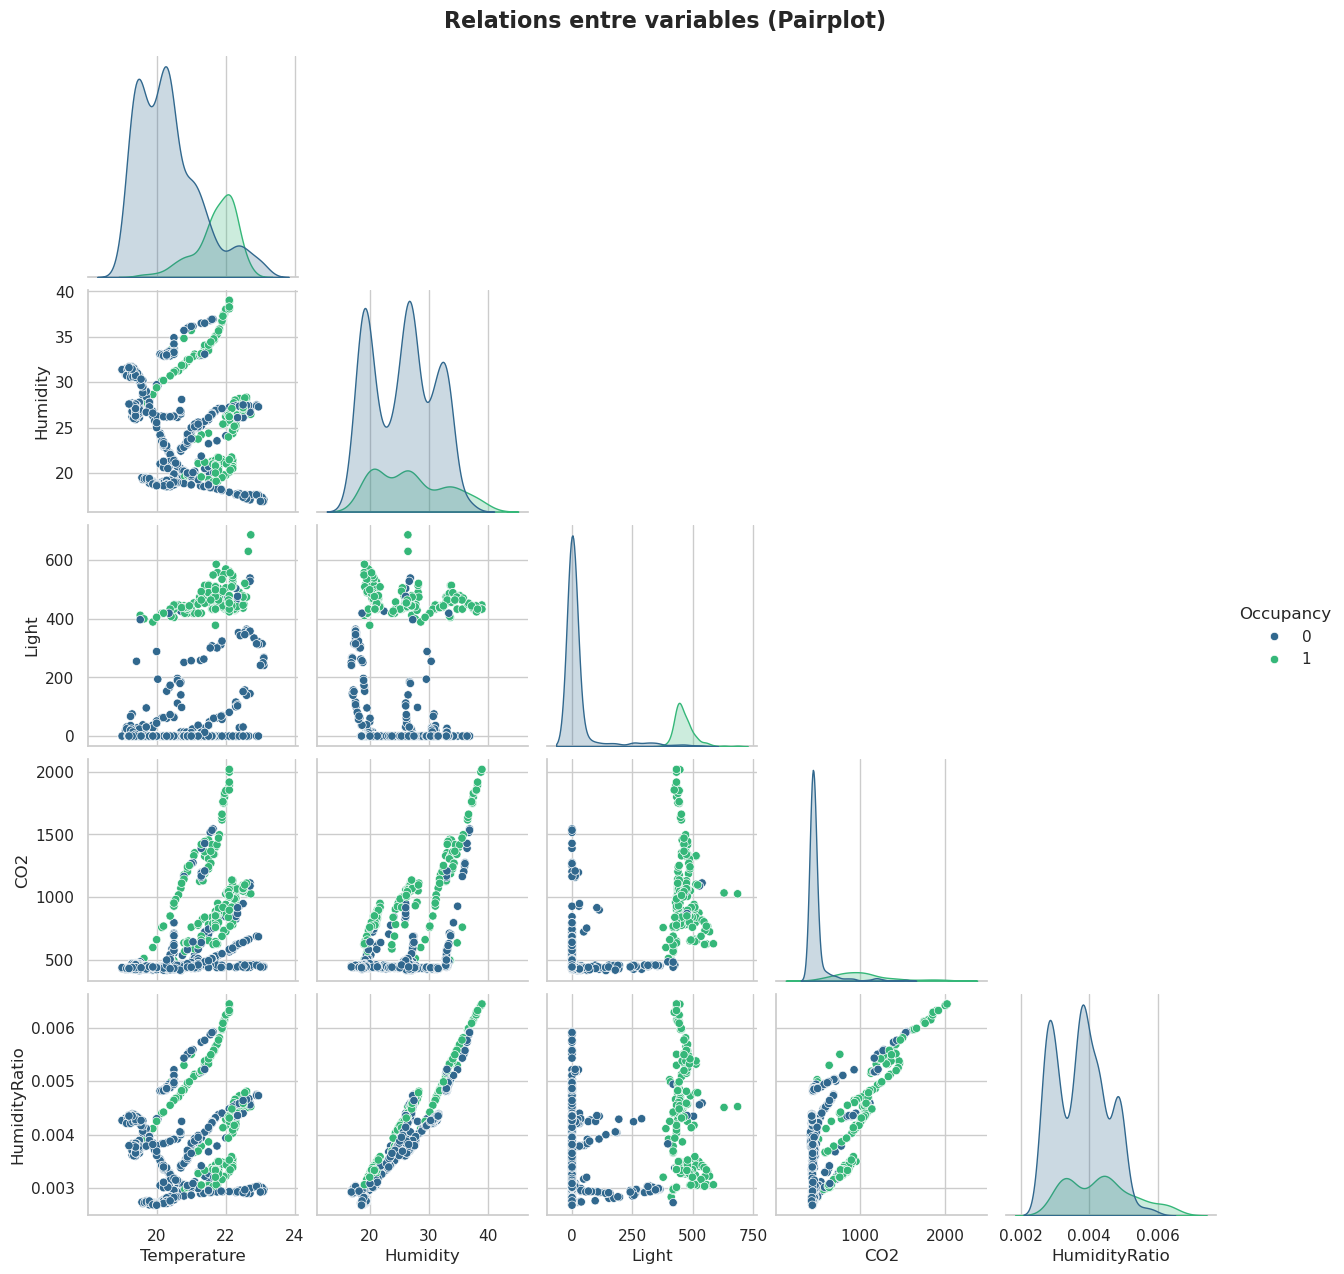

In [3]:
# Configuration du style global
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="whitegrid", context="notebook", palette="viridis")
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 12

# 1. Distribution de la cible (Occupancy)
plt.figure(figsize=(8, 5))
ax = sns.countplot(x='Occupancy', data=df, palette='viridis')
plt.title("Distribution des Classes (Occupancy)", fontsize=16, fontweight='bold')
plt.xlabel("Occupation (0=Non, 1=Oui)", fontsize=12)
plt.ylabel("Nombre d'échantillons", fontsize=12)

# Ajout des pourcentages
total = len(df)
for p in ax.patches:
    percentage = '{:.1f}%'.format(100 * p.get_height()/total)
    x = p.get_x() + p.get_width() / 2 - 0.05
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='bottom', fontweight='bold')
plt.show()

# 2. Matrice de Corrélation
plt.figure(figsize=(10, 8))
corr = df.corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
sns.heatmap(corr, mask=mask, annot=True, fmt=".2f", cmap='magma', 
            linewidths=1, cbar_kws={"shrink": .8})
plt.title("Matrice de Corrélation des Features", fontsize=16, fontweight='bold')
plt.show()

# 3. Pairplot (sur un échantillon pour la rapidité)
print("Génération du pairplot...")
sample_df = df.sample(min(1000, len(df)), random_state=42)
sns.pairplot(sample_df, hue='Occupancy', palette='viridis', corner=True)
plt.suptitle("Relations entre variables (Pairplot)", y=1.02, fontsize=16, fontweight='bold')
plt.show()

5. Prétraitement des Données

Dans cette section, on effectue :

un nettoyage

normalisation des features avec StandardScaler

séparation du dataset en trois ensembles : train, validation, test

L’objectif est de préparer une base propre pour les modèles.

In [4]:
X = df.drop('Occupancy', axis=1)
y = df['Occupancy']

# Split Train / Validation / Test
# On garde une partie pour le test final (20%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# On divise le reste en Train (pour les modèles de base) et Validation (pour le meta-modèle)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.25, random_state=42, stratify=y_temp) # 0.25 * 0.8 = 0.2

print(f"Train shape: {X_train.shape}")
print(f"Val shape: {X_val.shape}")
print(f"Test shape: {X_test.shape}")

# Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Sauvegarde du scaler
if not os.path.exists('../models'):
    os.makedirs('../models')
with open('../models/scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

Train shape: (4885, 5)
Val shape: (1629, 5)
Test shape: (1629, 5)


6. Entraînement des Quatre Modèles de Base

Cette partie est consacrée aux quatre modèles qu'on utilise dans le système :

Decision Tree

Random Forest

SVM avec estimation des probabilités

Naive Bayes

Pour chacun, on entraîne le modèle, calcule les métriques habituelles (Accuracy, F1-score) et observe leurs forces et faiblesses.

Les modèles sont ensuite sauvegardés au format .pkl

Entraînement et évaluation des modèles de base...
Accuracy Decision Tree: 0.9920
Accuracy Random Forest: 0.9945
Accuracy SVM: 0.9883
Accuracy Naive Bayes: 0.9810


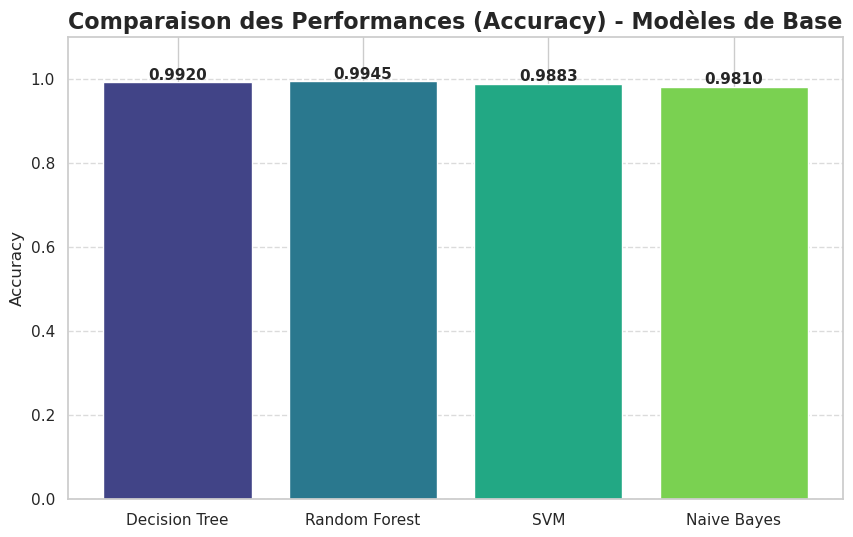

In [5]:
models = {
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "SVM": SVC(probability=True, random_state=42),
    "Naive Bayes": GaussianNB()
}

results = {}

print("Entraînement et évaluation des modèles de base...")
for name, model in models.items():
    model.fit(X_train_scaled, y_train)
    acc = model.score(X_val_scaled, y_val)
    results[name] = acc
    print(f"Accuracy {name}: {acc:.4f}")
    
    # Sauvegarde
    filename = f"../models/{name.lower().replace(' ', '_')}_model.pkl"
    with open(filename, 'wb') as f:
        pickle.dump(model, f)

# Visualisation des Performances
plt.figure(figsize=(10, 6))
colors = sns.color_palette("viridis", len(results))
bars = plt.bar(results.keys(), results.values(), color=colors)
plt.title("Comparaison des Performances (Accuracy) - Modèles de Base", fontsize=16, fontweight='bold')
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1.1)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.4f}',
             ha='center', va='bottom', fontsize=11, fontweight='bold')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

7. Construction des Métafeatures

Ici, on construis les méta-données qui servent au meta-modèle.
Pour chaque instance du validation set, on récupère :

la confiance maximale du modèle

la différence entre les deux meilleures probabilités (margin)

on fais cela pour les quatre classifieurs

In [6]:
def get_meta_features(models, X_scaled):
    meta_features = []
    
    # Pour chaque instance
    for i in range(len(X_scaled)):
        row_features = []
        sample = X_scaled[i].reshape(1, -1)
        
        for name, model in models.items():
            # Obtenir les probabilités [P(0), P(1)]
            probas = model.predict_proba(sample)[0]
            
            # 1. Confiance Max
            conf_max = np.max(probas)
            
            # 2. Margin (différence entre les deux meilleures probas - ici binaire donc |P(0)-P(1)|)
            # Pour multiclasse ce serait top1 - top2
            probas_sorted = np.sort(probas)
            margin = probas_sorted[-1] - probas_sorted[-2]
            
            row_features.extend([conf_max, margin])
            
        meta_features.append(row_features)
    
    return np.array(meta_features)

print("Fonction get_meta_features définie.")

Fonction get_meta_features définie.


8. Construction du Meta-Dataset

Dans cette section, on décide quel modèle de base “avait raison” pour chaque instance de validation.
Cela nous permet de créer le vecteur meta_y.

Cas particuliers gérés ici :

plusieurs modèles corrects → application de la stratégie fallback

aucun modèle correct → exclusion ou règle alternative

À la fin, on obtiens :

meta_X (méta-features)

meta_y (labels = modèle à choisir)

In [7]:
# 1. Générer Meta-X (features) sur le Validation Set
print("Génération des méta-features sur le validation set...")
meta_X = get_meta_features(models, X_val_scaled)

# 2. Générer Meta-Y (labels) : Quel modèle a raison ?
# Stratégie : On choisit le modèle qui a prédit correctement. 
# S'il y en a plusieurs, on peut prendre celui qui a la plus grande confiance, ou arbitrairement.
# Ici, simplifions : on prend l'index du premier modèle correct dans la liste, ou une classe 'Aucun' si tous ont tort.

meta_y = []
model_names = list(models.keys())

y_val_array = y_val.values

for i in range(len(X_val_scaled)):
    sample = X_val_scaled[i].reshape(1, -1)
    true_label = y_val_array[i]
    
    best_model_idx = -1
    best_conf = -1
    
    # On cherche le modèle correct avec la meilleure confiance
    for idx, (name, model) in enumerate(models.items()):
        pred = model.predict(sample)[0]
        probas = model.predict_proba(sample)[0]
        conf = np.max(probas)
        
        if pred == true_label:
            if conf > best_conf:
                best_conf = conf
                best_model_idx = idx
    
    # Fallback : si aucun n'a raison, on prend celui qui était le plus confiant (même si faux) 
    # OU on garde le best_model_idx = -1 et on gère ça. 
    # Pour simplifier le KNN, on force un choix : le plus confiant tout court si tous faux.
    if best_model_idx == -1:
        for idx, (name, model) in enumerate(models.items()):
             probas = model.predict_proba(sample)[0]
             conf = np.max(probas)
             if conf > best_conf:
                best_conf = conf
                best_model_idx = idx
                
    meta_y.append(best_model_idx)

meta_y = np.array(meta_y)
print(f"Meta-Dataset généré. Shape X: {meta_X.shape}, Shape y: {meta_y.shape}")

# --- EXPORT CSV ---
print("Export des meta-features en CSV...")
columns = []
for name in models.keys():
    columns.extend([f"Conf_{name}", f"Margin_{name}"])

df_meta = pd.DataFrame(meta_X, columns=columns)
df_meta['Target_Model_Index'] = meta_y
df_meta['Target_Model_Name'] = df_meta['Target_Model_Index'].apply(lambda i: list(models.keys())[i])

output_csv = '../donnees/meta_features.csv'
df_meta.to_csv(output_csv, index=False)
print(f"Fichier sauvegardé : {output_csv}")

Génération des méta-features sur le validation set...
Meta-Dataset généré. Shape X: (1629, 8), Shape y: (1629,)
Export des meta-features en CSV...
Fichier sauvegardé : ../donnees/meta_features.csv


9. Entraînement du Meta-Modèle (KNN)

on utilise un KNN (k = 5) comme meta-modèle.

Cette partie contient :

entraînement du KNN

validation rapide

sauvegarde du meta-modèle meta_knn.pkl

In [8]:
# Entraînement du KNN comme Meta-Modèle
meta_model = KNeighborsClassifier(n_neighbors=5)
meta_model.fit(meta_X, meta_y)

print("Meta-Modèle KNN entraîné.")

# Sauvegarde
with open('../models/meta_model_knn.pkl', 'wb') as f:
    pickle.dump(meta_model, f)

Meta-Modèle KNN entraîné.


10. Pipeline Complet d’Inférence

C’est une des parties les plus importantes du notebook.

Ici on construit une fonction complète capable de :

recevoir une nouvelle mesure → X

appliquer le scaler

faire prédire les 4 modèles de base

créer les méta-features

appliquer le KNN pour choisir un modèle

retourner la prédiction finale (occupé / non occupé)

Cette fonction est ensuite sauvegardée et exportée pour l’application Flask.

In [9]:
def full_pipeline_predict(values_dict, scaler, models, meta_model):
    # 1. Conversion et Scaling
    # Ordre des features : Temperature, Humidity, Light, CO2, HumidityRatio
    # Attention à l'ordre dans le dataframe original !
    # df.columns = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio', 'Occupancy'] (sans date)
    feature_order = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
    
    try:
        vector = [float(values_dict[f]) for f in feature_order]
    except KeyError as e:
        return None, f"Missing feature: {e}", 0.0
        
    vector_scaled = scaler.transform([vector])
    
    # 2. Prédictions de base et Méta-features
    meta_features_row = []
    base_predictions = {}
    
    for name, model in models.items():
        probas = model.predict_proba(vector_scaled)[0]
        conf_max = np.max(probas)
        probas_sorted = np.sort(probas)
        margin = probas_sorted[-1] - probas_sorted[-2]
        
        meta_features_row.extend([conf_max, margin])
        base_predictions[name] = {
            'pred': model.predict(vector_scaled)[0],
            'conf': conf_max
        }
        
    # 3. Choix du modèle via Meta-Modèle
    meta_features_row = np.array(meta_features_row).reshape(1, -1)
    selected_model_idx = meta_model.predict(meta_features_row)[0]
    selected_model_name = list(models.keys())[selected_model_idx]
    
    # 4. Résultat final
    final_pred = base_predictions[selected_model_name]['pred']
    final_conf = base_predictions[selected_model_name]['conf']
    
    return final_pred, selected_model_name, final_conf

print("Pipeline défini.")

Pipeline défini.


11. Évaluation Finale du Système

Dans cette section, on teste le pipeline complet sur le test set pour voir son comportement en situation réelle.
Les résultats affichés :

Accuracy finale

F1-score global

Matrice de confusion

Quelques prédictions 


Évaluation sur le Test Set...


/home/mg4/miniconda3/envs/Mg4_IA/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mg4/miniconda3/envs/Mg4_IA/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mg4/miniconda3/envs/Mg4_IA/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mg4/miniconda3/envs/Mg4_IA/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home/mg4/miniconda3/envs/Mg4_IA/lib/python3.10/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/home

Accuracy Finale du Système Meta-Learning : 0.9926


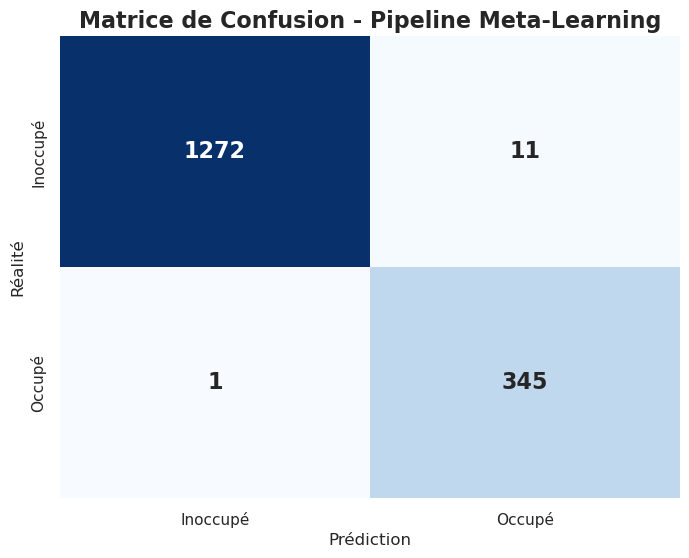

In [10]:
# Test sur le Test Set (jamais vu)
print("Évaluation sur le Test Set...")

y_true = []
y_pred = []

feature_order = ['Temperature', 'Humidity', 'Light', 'CO2', 'HumidityRatio']
X_test_df = pd.DataFrame(X_test, columns=feature_order)

for i in range(len(X_test)):
    row = X_test_df.iloc[i].to_dict()
    true_val = y_test.iloc[i]
    
    pred, model_name, conf = full_pipeline_predict(row, scaler, models, meta_model)
    
    y_true.append(true_val)
    y_pred.append(pred)

acc = accuracy_score(y_true, y_pred)
print(f"Accuracy Finale du Système Meta-Learning : {acc:.4f}")

# Matrice de Confusion Moderne
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Inoccupé', 'Occupé'],
            yticklabels=['Inoccupé', 'Occupé'],
            annot_kws={"size": 16, "weight": "bold"})
plt.title("Matrice de Confusion - Pipeline Meta-Learning", fontsize=16, fontweight='bold')
plt.xlabel("Prédiction", fontsize=12)
plt.ylabel("Réalité", fontsize=12)
plt.show()

12. Export et Préparation Flask

Ici, on exporte :

scaler

les quatre modèles

meta-knn

la fonction du pipeline final

on assure aussi qu’il est possible de recharger tout ce matériel et prédire en dehors du notebook.

In [11]:
# Tout est déjà sauvegardé dans ../models/
# - scaler.pkl
# - decision_tree_model.pkl
# - random_forest_model.pkl
# - svm_model.pkl
# - naive_bayes_model.pkl
# - meta_model_knn.pkl

print("Tous les modèles sont sauvegardés dans le dossier models/")

Tous les modèles sont sauvegardés dans le dossier models/
